In [59]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target, random_state=0)

scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

svm=SVC()
svm.fit(X_train_scaled,y_train)
print('Test score: {:.2f}'.format(svm.score(X_test_scaled,y_test)))

Test score: 0.97


# Parameter Selection with Preprocessing


In [60]:
## Nave Approch
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}
grid=GridSearchCV(SVC(),param_grid,cv=5)
grid.fit(X_train_scaled,y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled,y_test)))
print("Best Parameters: {}".format(grid.best_params_))

Best cross-validation score: 0.98
Best set score: 0.97
Best Parameters: {'C': 1, 'gamma': 1}


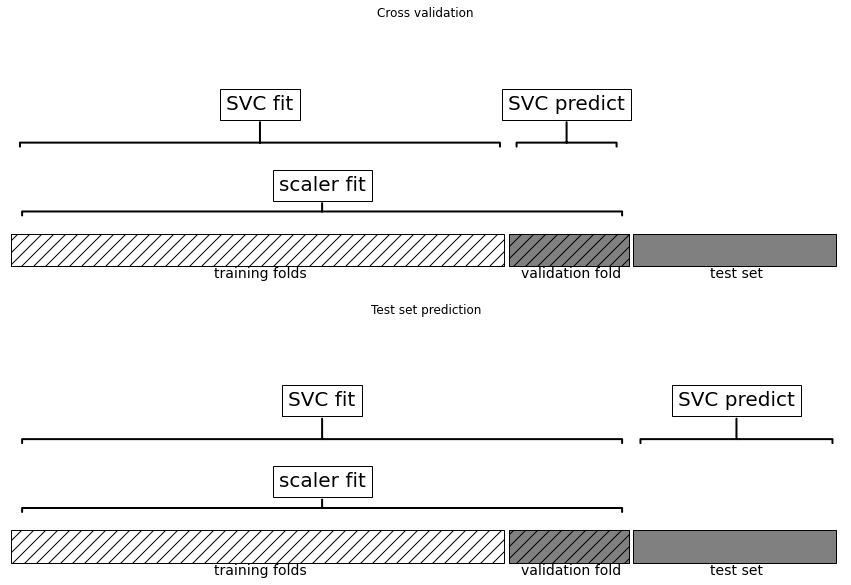

In [61]:
import mglearn
mglearn.plots.plot_improper_processing()

# Building Pipelines

In [62]:
from sklearn.pipeline import Pipeline
pipe=Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])

In [63]:
pipe.fit(X_train,y_train)
print("test score: {:.2f}".format(pipe.score(X_test,y_test)))

test score: 0.97


# Using Pipelines in Grid Searches

In [64]:
param_grid={'svm__C':[0.001,0.01,0.1,1,10,100],'svm__gamma':[0.001,0.01,0.1,1,10,100]}

grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test,y_test)))
print("Best Parameters: {}".format(grid.best_params_))

Best cross-validation score: 0.98
Best set score: 0.97
Best Parameters: {'svm__C': 1, 'svm__gamma': 1}


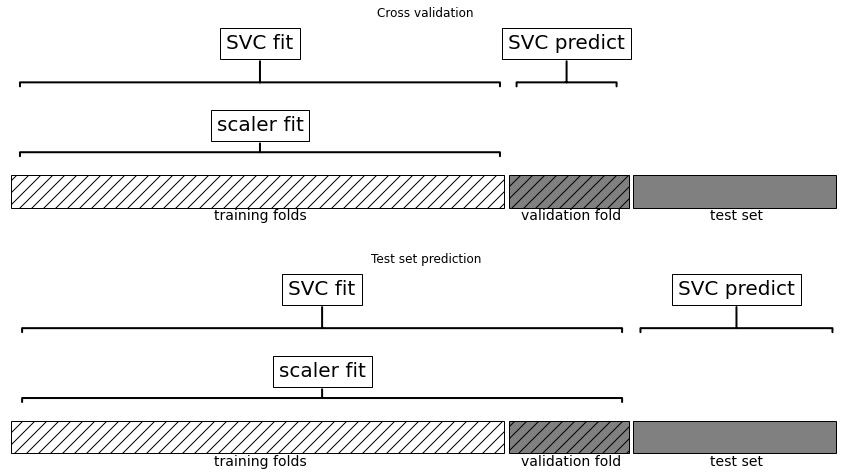

In [65]:
mglearn.plots.plot_proper_processing()

# Illustrating Information Leakage

In [66]:
import numpy as np 
rnd=np.random.RandomState(seed=0)
X=rnd.normal(size=(100,10000))
y=rnd.normal(size=(100,))

In [67]:
from sklearn.feature_selection import SelectPercentile,f_regression
select=SelectPercentile(score_func=f_regression,percentile=5).fit(X,y)
X_selected=select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge 
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(),X_selected,y,cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


In [69]:
pipe=Pipeline([("select",SelectPercentile(score_func=f_regression,percentile=5)),("ridge",Ridge())])
print("Cross-validation accuracy (pipline): {:.2f}".format(np.mean(cross_val_score(pipe,X,y,cv=5))))

Cross-validation accuracy (pipline): -0.25


# The General Pipeline Interface

In [70]:
# def fit(self,X,y):
#     X_transformed=X
#     for name,estimater in self.steps[:-1]:
#         #iterate over all but the final step
#         # fit and transform the data
#         X_transformed=estimater.fit_transform(X_transformed,y)

#     # fit the last step
#     self.steps[-1][1].fit(X_transformed,y)
#     return self

In [71]:
# def predict(self,X):
#     X_transformed=X
#     for step in self.steps[:-1]:
#         # iterate over all but the final step
#         # transform the data
#         X_transformed=step[1].transform(X_transformed)

#     return self.steps[-1][1].predict(X_transformed)

## Convenient Pipeline Creation with make_pipeline


In [72]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long=Pipeline([('scaler',MinMaxScaler()),('svm',SVC(C=100))])
pipe_short=make_pipeline(MinMaxScaler(),SVC(C=100))

In [73]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

pipe=make_pipeline(StandardScaler(),PCA(n_components=2), StandardScaler())
print('Pipeline steps:\n{}'.format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


## Accessing Step Attributes

In [75]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
components=pipe.named_steps["pca"].components_
print("components.shape:{}".format(components.shape))

components.shape:(2, 30)


## Accessing Attributes in a Grid-Searched Pipeline

In [76]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(),LogisticRegression())

In [77]:
param_grid={'logisticregression__C':[0.01,0.1,1,10,100]}

In [78]:
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=4)
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [79]:
print("Best Estimater:\n{}".format(grid.best_estimator_))

Best Estimater:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


In [80]:
print("Logistic regression step:\n{}".format(
grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1)


In [81]:
print("Logistic regression coefficients:\n{}".format(
grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# Grid-Searching Preprocessing Steps and Model Parameters


In [85]:
from sklearn.datasets import load_boston
boston=load_boston()
X_train,X_test,y_train,y_test=train_test_split(boston.data,boston.target,random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe=make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

In [86]:
param_grid={'polynomialfeatures__degree':[1,2,3],'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

In [87]:
grid=GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

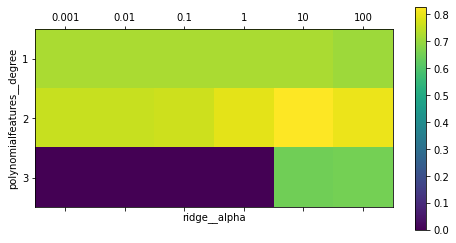

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [90]:
print('Best parameters: {}'.format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [91]:
print("test-set score: {:.2f}".format(grid.score(X_test,y_test)))

test-set score: 0.77


In [93]:
param_grid={'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe=make_pipeline(StandardScaler(),Ridge())
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test,y_test)))

Score without poly features: 0.63


# Grid-Searching which model to use

In [99]:
pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])

In [100]:
from sklearn.ensemble import RandomForestClassifier
param_grid=[{'classifier':[SVC()],'preprocessing':[StandardScaler(),None],'classifier__gamma':[0.001,0.01,0.1,1,10,100],'classifier__C':[0.001,0.01,0.1,1,10,100]},
{'classifier':[RandomForestClassifier(n_estimators=100)],'preprocessing':[None],'classifier__max_features':[1,2,3]}]

In [101]:
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best cross-validation score:{:.2f}".format(grid.best_score_))
print("test-set score:{:.2f}".format(grid.score(X_test,y_test)))


Best parameters:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score:0.99
test-set score:0.98
